![Tulane](https://github.com/tulane-cmps6730/main/blob/main/img/banner.png?raw=true)

<center>

<font size="+3">Classification II</font>

[Aron Culotta](https://cs.tulane.edu/~aculotta/)  
[Tulane University](https://cs.tulane.edu/)

<a href="http://colab.research.google.com/github/tulane-cmps6730/main/blob/main/notebooks/03_Classification_2.ipynb">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Google_Colaboratory_SVG_Logo.svg/320px-Google_Colaboratory_SVG_Logo.svg.png"  width=10%/></a>
<a href="https://github.com/tulane-cmps6730/main/tree/main">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/GitHub_Invertocat_Logo.svg/240px-GitHub_Invertocat_Logo.svg.png" width=6%/></a>

In this module, we'll learn about neural networks and how better data representations can improve classification.

</center>

<hr size=10 color=#285C4D>

## Reviewing Logistic Regression



First, let's review what we learned about logistic regression.

We'll walk through a simple example using the `LogisticRegression` class in the [scikit-learn](https://scikit-learn.org/stable/) library.

We begin with common imports and our toy spam classification example:

In [19]:
# common imports
import matplotlib.pyplot as plt
import numpy as np
from numpy import array as npa
import pandas as pd

D = pd.DataFrame(
        [[0,0,-1],
        [1,0,-1],
        [1,0,-1],
        [1,1,1],
        [1,1,1],
        [1,1,1],
        [0,0,-1],
        [0,0,-1],
        [0,1,-1]], columns=['free', 'money', 'label'])
D

,free,money,label
0,0,0,-1
1,1,0,-1
2,1,0,-1
3,1,1,1
4,1,1,1
5,1,1,1
6,0,0,-1
7,0,0,-1
8,0,1,-1


In [20]:
# Fit LogisticRegression on this data.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# create feature matrix
X = D[['free', 'money']].values
# create label vector
y = D.label.values
print("X: feature matrix")
display(X)
print("\ny: label vector")
display(y)
# fit the parameters - this will do gradient descent.
lr.fit(X, y)
# print the learned coefficients and intercept terms.
print('learned coeficients (theta)=', lr.coef_)
print('intercept=', lr.intercept_)

X: feature matrix


array([[0, 0],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 1]])


y: label vector


array([-1, -1, -1,  1,  1,  1, -1, -1, -1])

learned coeficients (theta)= [[0.8057828  1.04466014]]
intercept= [-1.69903235]


In [21]:
# how many iterations of gradient descent were required?
lr.n_iter_[0]

7

### Decision boundaries

Logistic regression produces a **linear decision boundary** between the classes.

(Note this is true even though the logistic function itself is non-linear.)

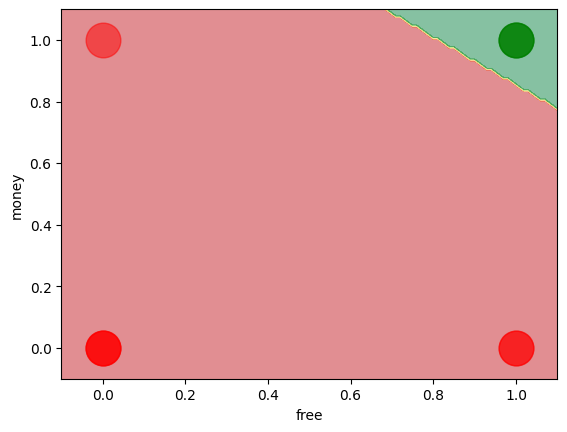

In [22]:
def plot_data(X, y, x0, x1):
    for xi, yi in zip(X, y):
        plt.plot(xi[0], xi[1], marker='.', ms=50, color='g' if yi == 1 else 'r', alpha=.5)
    plt.xlabel(x0)
    plt.ylabel(x1)

def plot_decision_surface(clf):
    xx0, xx1 = np.meshgrid(np.arange(-0.1, 1.1, .01), np.arange(-0.1, 1.1, .01))
    Z = clf.predict(np.c_[xx0.ravel(), xx1.ravel()])
    Z = Z.reshape(xx0.shape)
    cs = plt.contourf(xx0, xx1, Z, cmap=plt.cm.RdYlGn, alpha=.5)


plt.figure()
plot_data(X, y, 'free', 'money')
plot_decision_surface(lr)
plt.show()

**Why would we ever need a more complicated decision boundary?**

In [23]:
# "free free" -> not spam ?
lr.predict([[2, 0]])

array([-1])

### More complex decision functions

Consider more complicated rules you might write for spam detection.

- If document contains "free money" or "free credit report" but not "free tonight" ....


<br>

or consider sentiment classification (e.g., is this a positive or negative restaurant review):

- If document contains "bad" -> negative  
- If document contains "not bad" -> positive

or:

- If document contains a bad comment about service -> negative  
- If document contains bad comment about weather and good comment about food -> positive



**We need the flexibility to represent complex word interactions, without having to predefine them ourselves.**


Consider having many classifiers for each possible topic:

- weather sentiment
- food sentiment
- service sentiment
- ...

We could then combine into a final overall sentiment prediction.

In [24]:
D = pd.DataFrame(
        [[1,0,0,1],
        [-1,0,0,-1],
        [1,0,-1,1],
        [1,0,-1,1],
        [-1,0,1,-1],
        [-1,0,-1,-1],
        [1,1,1,1],
        [1,1,-1,1]], columns=['food', 'service', 'weather', 'label'])
D

,food,service,weather,label
0,1,0,0,1
1,-1,0,0,-1
2,1,0,-1,1
3,1,0,-1,1
4,-1,0,1,-1
5,-1,0,-1,-1
6,1,1,1,1
7,1,1,-1,1


In [25]:
X = D[['food', 'service', 'weather']].values
y = D.label.values
lr.fit(X, y)
print('coef=', lr.coef_)
print('intercept=', lr.intercept_)

coef= [[ 1.41135853  0.26270113 -0.17675799]]
intercept= [0.2265434]


...but, how do we discover that 'food', 'service', and 'weather' are important?

$\rightarrow$ **discover from the data.**

That's the idea behind neural networks: learn a **data representation** that is most predictive of class label.


<hr size=10 color=#285C4D>

## Neural Networks Overview



A neural network is a metaphor for describing computation.

<u> Logistic Regression as a Neural Network </u>

![nn](https://github.com/tulane-cmps6730/main/blob/main/lec/classify/figs/nn.png?raw=1)

### Multi-layer Neural Network

Neural networks typically consist of multiple **layers**. Each layer receives an input from the proceeding layer, performs computation, then produces an output.

![nn2](https://github.com/tulane-cmps6730/main/blob/main/lec/classify/figs/nn2.png?raw=1)

Introduce $m$ <u> hidden nodes</u> $\vec{h} = \{h_1 \ldots h_m\}$.
- Like $m$ different classifiers (e.g., for "service", "food", "weather", ...)
  - Each with own set of parameters $\Theta = \{\Theta^1 \ldots \Theta^m\}$
  - e.g. $\vec{\Theta}^1 = \{\theta_1^1 \ldots \theta_d^1\}$
    - $\theta_i^j$: weight connecting input $i$ to hidden node $j$
- But, no associated labeled data for those classifiers.

Also introduce a classifier to map from hidden values $\vec{h}$ to label $y$
- with parameters $\vec{\lambda} = \{\lambda_1 \ldots \lambda_m\}$

<u>Conceptually</u>
- Identify $m$ different transformations of the input
- Combine those $m$ transformations into a prediction
- Allows <u> nonlinear</u> prediction functions


<br>

Whereas logistic regression function is:

$$f(\vec{x}, \vec{\theta}) = \frac{1}{1 + e^{-\vec{x} \cdot \vec{\theta}}}$$

the  neural net above defines the function:

$$f(\vec{x}, \Theta, \vec{\lambda}) = \frac{1}{1 + e^{-\vec{h} \cdot \vec{\lambda}}}$$

where

$$
h_i =  \frac{1}{1 + e^{-\vec{x} \cdot \vec{\Theta^i}}}
$$



<hr size=10 color=#285C4D>

## XOR problem



Consider the XOR problem. The input is two bits, and the output is 1 if exactly one of the inputs is 1.

| $x_{1}$  | $x_{2}$ | $y$ |
|----------|----------|-------|
| 0        |     0    |  0    |
| 0        |     1    |  1    |
| 1        |     0    |  1    |
| 1        |     1    |  0    |

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/classify/figs/xor.png?raw=1" width="30%"/>

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/classify/figs/xor2.png?raw=1" width="30%"/>


| $x_{1}$  | $x_{2}$  | $h_{1}$ | $h_{2}$ | $y_i$ |
|----------|----------|---------|---------|-------|
| 0        |     0    |  0      | 0       | 0     |
| 0        |     1    |  1      | -1      | 1     |
| 1        |     0    |  -1     | 1       | 1     |
| 1        |     1    |  0      | 0       | 0     |



<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/classify/figs/xor3.png?raw=1" width="70%"/>




<hr size=10 color=#285C4D>

## Learning in neural nets



Consider the three layer neural network.  
How can we learn the parameters $\Theta$ and $\vec{\lambda}$?

![nn2](https://github.com/tulane-cmps6730/main/blob/main/lec/classify/figs/nn2.png?raw=1)




### Recall Gradient descent recipe

1.  Select a model type (e.g., linear, polynomial, etc)

2.  Select an **error function** that, when minimized, results in a good setting of the model parameters.

3.  Analytically determine the gradient of the error function with respect to the model parameters.

4.  Iteratively change the parameters by a small amount in the direction of the gradient until the (near) minimum of the error function is found.


<br><br>

Our function is now:

$$f(\vec{x}, \Theta, \vec{\lambda}) = \frac{1}{1 + e^{-\vec{h} \cdot \vec{\lambda}}}$$

where

$$
h_i =  \frac{1}{1 + e^{-\vec{x} \cdot \vec{\Theta^i}}}
$$

<br>

As with logistic regression, we can write the probability of the correct label as:

$$
p(y \mid \vec{x}) = \frac{1}{1 + e^{-y\vec{h} \cdot \vec{\lambda}}}
$$

<br><br><br>

We can choose from many possible error functions, e.g. **negative likelihood**:

$$
E(D, \lambda, \Theta) = - \prod_{i=1}^{n}p(y_i|\vec{x}_i)
$$



then, we need to compute two gradients:
- $\frac{\partial E}{\partial{\theta_i^j}}$
- $\frac{\partial E}{\partial{\lambda_{j}}}$  
<br>
where   
- $\lambda_{j}$ is the weight from hidden unit $j$ to the output unit
- $\theta_i^j$ is weight from input node $i$ to hidden unit $j$

The gradient depends on three things:

1. The network structure (hidden layers, units)
2. The activation function (here, the logistic function)
3. The loss function (e.g., squared error, cross entropy, ...)

<br>
<br>



### Parameter updates

Assuming logistic activation functions and negative log likelihood loss function, we can compute the update rules as follows (messy calculus omitted).

We compute updates for a single training instance (to reduce subscripts).

1. $\vec{\lambda}$ parameters are just updated like in logistic regression, replacing $h_j$ for feature $x_j$:

$$
\lambda_j^{t+1} \leftarrow \lambda_j^t + \eta y h_j (1-p(y \mid \vec{h}))
$$

> Compare with logistic regression update for one training instance: $$\theta_j^{t+1} \leftarrow \theta_j^{t} + \eta y x_{j}(1-p(y \mid \vec{x}))$$

<br>

2. To compute updates for $\Theta$, we need to "assign blame" to each hidden unit proportionally:

$$
\theta_{i}^{j (t+1)} \leftarrow \theta_{i}^{j (t)} + \eta y x_i \lambda_j(1 - p(y \mid \vec{h}))
$$
- $\theta_{i}^{j}$ is the weight connecting input feature $i$ to hidden node $j$
- $\lambda_j$ weights the influence of hidden node $h_j$ on the final classification $y$
- $x_i$ indicates the influence of the $i$th input feature on hidden node $h_j$
 - In picuture below, this is $x_{1i}$, but we've dropped the example index for simplicity.

![nn2](https://github.com/tulane-cmps6730/main/blob/main/lec/classify/figs/nn2.png?raw=1)


<br><br>




### Stochastic gradient descent

Rather than sum over all instances, parameters are separately for small batch of examples.


Gradient descent in neural networks is often called <u> back-propagation</u>,  since the errors/updates at layer $i$ are propagated back to layer $i-1$.

Modern libraries allow use **autodifferentiation** to let you change network structure, activation, and loss functions without having to derive gradients by hand.

<br>



<hr size=10 color=#285C4D>

## XOR Revisited



Now that we know a bit about neural networks, let's revisit the XOR problem.

We will generate data that approximately represent the XOR function (e.g., inputs can be close to 0 or 1). Then, we will compare the decision functions learned by logistic regression and neural networks.

Inputs x1 and x2:
[[ 4.71435164e-03 -1.19097569e-02]
 [ 1.43270697e-02 -3.12651896e-03]
 [-7.20588733e-03  8.87162940e-03]
 [ 8.59588414e-03  9.93634765e-01]
 [ 1.56963721e-04  9.77573150e-01]
 [ 1.15003572e-02  1.00991946e+00]
 [ 1.00953324e+00 -2.02125482e-02]
 [ 9.96659226e-01  2.11836468e-05]
 [ 1.00405453e+00  2.89091941e-03]
 [ 1.01321158e+00  9.84530944e-01]
 [ 9.97973537e-01  9.93440307e-01]
 [ 1.00193421e+00  1.00553439e+00]]

Labels y
[0 0 0 1 1 1 1 1 1 0 0 0]


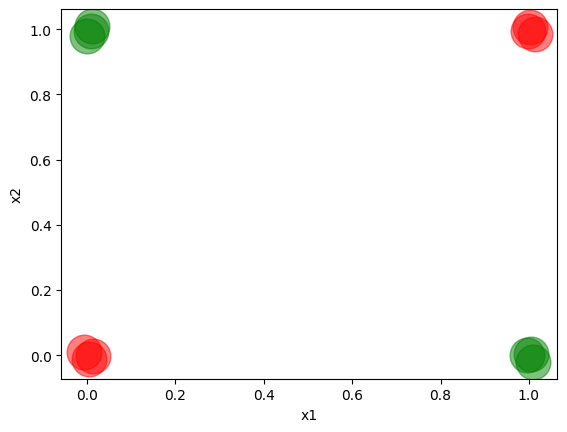

In [26]:
# create some noisy samples from XOR function

def create_xor_data(n):
    np.random.seed(1234)
    ni = int(n / 4)
    d00 = [[0,0] + np.random.randn(2)/1e2 for i in range(ni)]
    d01 = [[0,1] + np.random.randn(2)/1e2 for i in range(ni)]
    d10 = [[1,0] + np.random.randn(2)/1e2 for i in range(ni)]
    d11 = [[1,1] + np.random.randn(2)/1e2 for i in range(ni)]
    y = [0] * ni + [1] * ni * 2 + [0] * ni
    return np.vstack([d00, d01, d10, d11]), np.array(y)

X, y = create_xor_data(12)
print('Inputs x1 and x2:')
print(X)
print('\nLabels y')
print(y)

plt.figure()
plot_data(X, y, 'x1', 'x2')
plt.show()

coef= [[ 0.00188596 -0.00370041]]
intercept= [0.00078934]


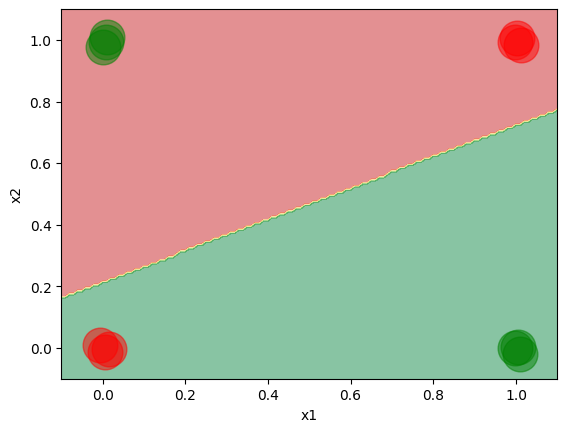

In [27]:
# Fit LogisticRegression and plot the decision surface

lr.fit(X, y)
print('coef=', lr.coef_)
print('intercept=', lr.intercept_)
plt.figure()
plot_data(X, y, 'x1', 'x2')
plot_decision_surface(lr)
plt.show()


We can see that logistic regression is getting about half the instances incorrect (all the red dots in the green region and all the green dots in the red region). This demonstrates that a line is insufficient to separate the instances into their correct classes.

Now, let's repeat with a neural network. We will use the `MLPClassifier` implementation from scikit-learn (which stands for Multi-Layer Perceptron).

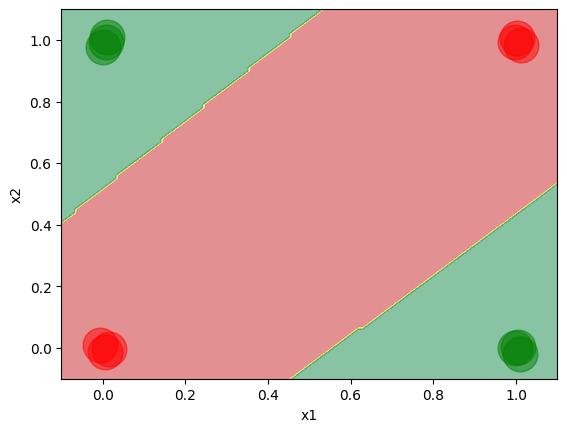

In [28]:
# Fit a neural net and plot the decision surface.
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=[2],
                    activation='logistic', # activation function
                    solver='lbfgs',        # a variant of gradient descent
                    random_state=1234)     # to ensure we get the same answer every time (weights are randomly initialized)
mlp.fit(X, y)
plt.figure()
plot_data(X, y, 'x1', 'x2')
plot_decision_surface(mlp)
plt.show()

<hr size=10 color=#285C4D>

## Inspecting Neural Network Internals



Here, we can see that the neural network perfectly classifies all instances. It does so by learning a more complicated surface. Let's look more closely on what it has learned.

The `MLPClassifier` object has a variable `coef_` that represents the weights of the network.
- Each element in `coef_` is a 2d weight matrix representing the weights between two adjacent layers in the network.
- For each 2d matrix, the row index corresponds to an element of the input layer, and the column corresponds to an element of the output layer.

So, the value in `coef_[i][j][k]` represents a weight connecting input element `j` in layer `i` to output element `k` in layer `i+1`.

Below, we first print the $\Theta$ weights, which map the input features to the hidden units (layers 0 to 1).

In [29]:
from IPython.display import display, Markdown

# input -> hidden layer weights.
thetas = pd.DataFrame(mlp.coefs_[0], columns=['$\Theta^1$', "$\Theta^2$"])
display(Markdown(thetas.to_markdown()))
# first column are parameters used to compute first hidden unit
# second column are used to compute second hidden unit

|    |   $\Theta^1$ |   $\Theta^2$ |
|---:|-------------:|-------------:|
|  0 |     -7.15116 |     -6.69425 |
|  1 |      7.22342 |      6.11507 |

Next we print the $\Lambda$ weights which map the hidden units to the output unit (layers 1 to 2).

In [30]:
# hidden -> output layer weights
lambdas = pd.DataFrame(mlp.coefs_[1], columns=["$\Lambda$"])
display(Markdown(lambdas.to_markdown()))

|    |   $\Lambda$ |
|---:|------------:|
|  0 |    -17.0622 |
|  1 |     16.1954 |

In [31]:
# each layer also has intercept terms...
mlp.intercepts_

[array([ 4.08723545, -3.14174212]), array([8.88823155])]

In [32]:
mlp.coefs_

[array([[-7.15116357, -6.6942545 ],
        [ 7.22341796,  6.11507215]]),
 array([[-17.06217213],
        [ 16.19541256]])]

Below we implement the activation functions so that we can compute the value of each hidden unit. The array offsets get a bit confusing here. Keep in mind that the `coefs_` variable represents a 3d matrix in the form: `[layer number][input unit number][output unit number]`

In [33]:
# constructing all the parameter vectors to also include intercept terms.
theta1 = np.array([mlp.coefs_[0][0][0], mlp.coefs_[0][1][0], mlp.intercepts_[0][0]])
theta2 = np.array([mlp.coefs_[0][0][1], mlp.coefs_[0][1][1], mlp.intercepts_[0][1]])
lambda1 = np.array([mlp.coefs_[1][0][0], mlp.coefs_[1][1][0], mlp.intercepts_[1][0]], dtype=object)
print('theta1', theta1)
print('theta2', theta2)
print('lambda1', lambda1)

theta1 [-7.15116357  7.22341796  4.08723545]
theta2 [-6.6942545   6.11507215 -3.14174212]
lambda1 [-17.062172127671683 16.19541255671539 8.88823155168317]


In [34]:
from math import exp

def f(x, theta):
  # dot product
  return np.dot(x.T, theta)

def logistic(x, theta):
  # logistic function
  return 1 / (1 + exp(-f(x, theta)))

def projection(x, theta1, theta2):
    """
    Project input x into values for h0 and h1
    First step of the "forward" pass of a neural net.
    """
    h0x = logistic(x, theta1)
    h1x = logistic(x, theta2)
    return h0x, h1x

# project (0,0) to hidden units
# note: add 1 for intercept term
h1, h2 = projection(np.array([0,0,1]), theta1, theta2)
print('h1', h1)
print('h2', h2)

h1 0.9834915300992804
h2 0.041417897674826544


The final layer of the network is equivalent to a LogisticRegression classifier. So, we will just create a `LogisticRegression` object representing that layer, using the $\Lambda$ weights as its parameters.

In [35]:
# create a LogisticRegression output for the final layer
outclf = LogisticRegression()
outclf.fit(X,y)  # just creating dummy variables
outclf.intercept_ = lambda1[2]
outclf.coef_ = np.array([[lambda1[0], lambda1[1]]])

Now, we can plot the decision surface of the neural network.

The axes of the plot correspond to the values of the hidden units `h0` and `h1`.

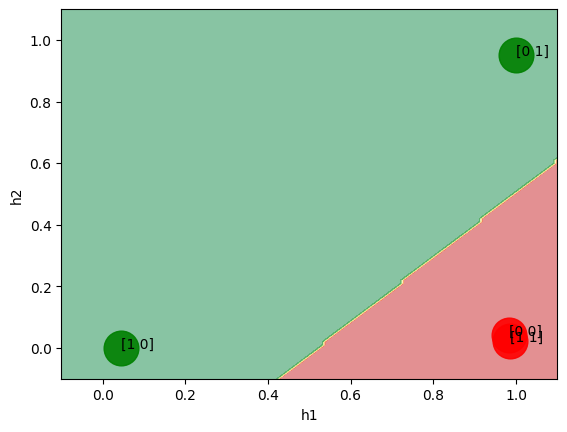

In [36]:
# plot decision surface in projected space.
def xor(p0, p1):
    return p0 != p1

plt.figure()
for xi in np.array([[0,0,1], [0,1,1], [1,0,1], [1,1,1]]):
    p0, p1 = projection(xi, theta1, theta2)
    plt.plot(p0, p1, marker='.', ms=50, color='g' if xor(xi[0], xi[1]) else 'r', alpha=.9)
    plt.annotate(str(xi[:2]), (p0, p1))
plot_decision_surface(outclf)
plt.xlabel('h1')
plt.ylabel('h2')
plt.show()

We can see that, in this projected space `(h1, h2)`, a linear decision surface perfectly separates the two classes. This is precisely how neural networks help -- they discover a projection (representation) of the input that makes classification easier.

<hr size=10 color=#285C4D>

## Neural network variants



In the preceding, we have shown one specific neural network architecture. There are many variations on this, and the ones most commonly used in practice differ in several ways.

### Error Functions

In addition to likelihood, we can consider many other error functions, given true label $y_i$ and predicted output $\hat{y}_i$ for instance $i$:

- Squared Error:
$$\sum_i (y_i - \hat{y}_i)^2 $$

- Cross-entropy
$$ \sum_i y_i \ln \hat{y}_i + (1-y_i)\ln(1-\hat{y}_i)$$



### Activation functions

Similarly, we have many choices for activation function:

- Sigmoid:
$$ f(t) = \frac{1}{1 + e^{-t}} $$

- Rectified linear function
$$ f(t) = \mathrm{max}(0, t)$$

- tanh
$$f(t) = \frac{e^t - e^{-t}}{e^t + e^{-t}}$$

- Softmax
$$ f(t_i) = \frac{e^{t_i}}{\sum_j e^{t_j}}$$

![figs/activation.png](https://github.com/tulane-cmps6730/main/blob/main/lec/classify/figs/activation.png?raw=1)

[source](https://github.com/jacobeisenstein/gt-nlp-class)

This choice can affect learning rate and convergence. Additional reading on [vanishing and exploding gradients](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)!


We will revisit these issues later on in the course.

<hr size=10 color=#285C4D>



## Group Task

Experiment with the neural network above to examine how different settings affect the final decision surface as well as the ability of the network to solve the XOR problem.

- Begin with 1 hidden unit and gradually increase the number of hidden units (e.g., try 1, 2, 4, 6, and 8).
- For each architecture, train the neural network and plot the decision surface.

In Canvas, enter your response to the following questions?
- How does increasing the number of hidden units change the decision boundary?
- At what point does the network start to solve the XOR problem effectively?